In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from pprint import pprint


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# create inspector object
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
def print_column_names(inspector, table_name):
    """prints out the column names and column types of a table

    Args:
        inspector (sqlalchemy.inspect): inspector object created inspect(engine)
        table_name (string): name of table in engine
    """
    
    for column in inspector.get_columns(table_name):
        print(column['name'], column["type"])
        
print_column_names(inspector=inspector, table_name='measurement')


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Find the most recent date in the data set.
max_date = session.query(func.max(Measurement.date)).scalar()

# extract the year, month and day from max_date as integers
max_year, max_month, max_day = [int(i) for i in max_date.split('-')]

print(f"The maximum date in the dataset is {max_year}-{max_month}-{max_day}")




The maximum date in the dataset is 2017-8-23


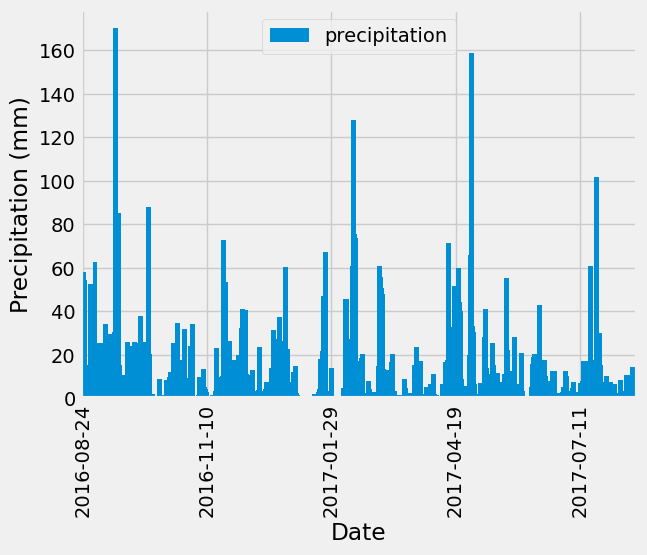

In [12]:
# calculate the minimum date for query
min_date = dt.date(max_year, max_month, max_day) - dt.timedelta(weeks=52)

# query result that selects all temperature data after a given start date
query = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= min_date)

# Convert the result set to a pandas DataFrame
precipitation_df = pd.DataFrame(query, columns=['date', 'precipitation'])

# Convert the date column to datetime format 
precipitation_df['date'] = pd.to_datetime(precipitation_df['date'])

# sort by date using pandas
precipitation_df = precipitation_df.sort_values(by='date', axis=0, ascending=True , ignore_index=True)

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot.bar(x='date', y='precipitation', grid=True, width=20)
tick_pos = np.arange(0, 2500, 500)
tick_labels = [(precipitation_df.iloc[i, 0].date()) for i in tick_pos]

plt.xticks(tick_pos, tick_labels);
plt.ylabel('Precipitation (mm)')
plt.xlabel('Date')
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df['precipitation'].describe()

count    2015.000000
mean        4.485112
std        11.690532
min         0.000000
25%         0.000000
50%         0.500000
75%         3.300000
max       170.200000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [14]:
# exploring the columns of station table

print_column_names(inspector=inspector, table_name='station')

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Design a query to calculate the total number of stations in the dataset
query_count = session.query(Station.station).count()
query_count

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_count = session.query(Measurement.station, func.count(Measurement.station).label('count'))\
                    .group_by(Measurement.station)\
                    .order_by(func.count(Measurement.station).desc())\
                    .all()

for station in station_count:
    print(station)
                              

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = station_count[0][0]
min_max_avg_temp_MAS = session.query(func.min(Measurement.tobs), \
                            func.max(Measurement.tobs), \
                            func.avg(Measurement.tobs)).\
                            filter(Measurement.station == most_active_station).\
                            all()
print(min_max_avg_temp_MAS)

[(12.2, 29.4, 22.035822510822513)]


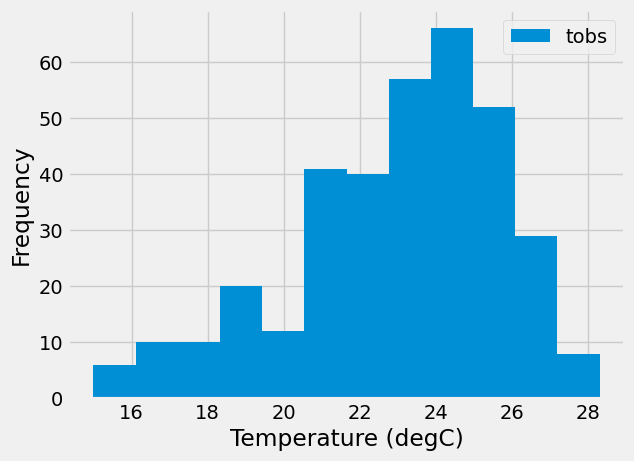

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperatures_MAS = session.query(Measurement.tobs).filter(Measurement.date >= min_date).\
        filter(Measurement.station == most_active_station).\
        all()
temperatures_MAS = np.squeeze(temperatures_MAS) # changes a list of single valued tuples into a single numpy array
plt.hist(temperatures_MAS, bins=12, label='tobs');
plt.legend()
plt.xlabel('Temperature (degC)')
plt.ylabel('Frequency');
plt.show()

# Close Session

In [240]:
# Close Session
session.close()
